In [89]:
import numpy as np
import matplotlib.pyplot as plt

In [90]:
# Parameters
beta = 4
sdim = 512

In [91]:
# Set Seed
np.random.seed(117);

In [92]:
# Build power spectrum 
f = [x/sdim for x in range(1, int(sdim/2)+1)] + [x/sdim for x in range(-int(sdim/2), 0)]
u = np.reshape(f, (sdim, 1))
v = np.reshape(f, (1, sdim))
w = np.reshape(f, (sdim, 1, 1))
pattern = (u**2 + v**2 + w**2)**(-beta/2)

In [93]:
# Noise and ifft
phases = np.random.normal(0, 255, size=[sdim, sdim, sdim]);
pattern = np.fft.ifftn(pattern**0.5 * (np.cos(2*np.pi*phases)+1j*np.sin(2*np.pi*phases)))

In [94]:
# Normalize result
pattern = np.real(pattern)
pattern = (pattern-np.amin(pattern))/np.amax(pattern-np.amin(pattern))

In [95]:
# Binarize result for box counting
threshold, upper, lower = 0.5, 1, 0
pattern = np.asarray(np.where(pattern>threshold, upper, lower))

In [98]:
def fractal_dimension_3d(Z, threshold=0.9):

    # Only for 3d volume
    assert(len(Z.shape) == 3)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):

        reducer = np.add.reduceat(np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0), np.arange(0, Z.shape[1], k), axis=1)

        S = np.add.reduceat(reducer, np.arange(0, Z.shape[2], k), axis=2)
        #print(S.shape)
        
        # We count non-empty (0) and non-full boxes (k*k) (is this right for 3d?)
        return len(np.where((S > 0) & (S < k*k*k))[0])

    #Transform Z into a binary array
    #Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n-1, 0, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        #print(size)
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    m, b = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -m, b, sizes, counts

def fractal_dimension_2d(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        #print(S.shape)
        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    #Transform Z into a binary array
    #Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n-1, 0, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        #print(size)
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    m, b = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -m, b, sizes, counts

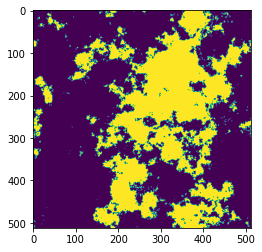

In [99]:
test2d = pattern[-1,:,:]
plt.imshow(test2d)

In [105]:
avg2d = []

for i in range(len(pattern)):
  slope2d, intercept2d, sz2d, count2d = fractal_dimension_2d(pattern[i,:,:])
  avg2d.append(slope2d)

slope2d = np.mean(avg2d)

In [101]:
fractal_dimension_3d(np.asarray(pattern))

(2.6605986593487443,
 17.206956879714728,
 array([256, 128,  64,  32,  16,   8,   4,   2]),
 [8, 64, 511, 3981, 27341, 157711, 757372, 2620008])

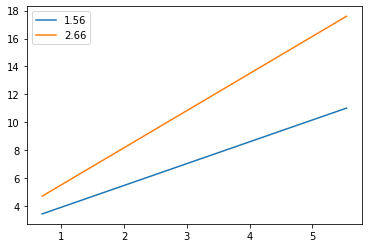

In [106]:
plt.plot(np.log(sz2d), slope2d*np.log(sz2d)+np.log(intercept2d), label=f"{round(slope2d, 2)}")

slope3d, intercept3d, sz3d, count3d = fractal_dimension_3d(np.asarray(pattern))
plt.plot(np.log(sz3d), slope3d*np.log(sz3d)+np.log(intercept3d), label=f"{round(slope3d, 2)}")

leg = plt.legend()
plt.show()